## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [13]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    
    shape = img.shape[1::-1]
    
    if shape[0] != 1280 or shape[1] != 720:
        print('Skipping image with non-standart shape: ', shape)
        continue
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(100)

cv2.destroyAllWindows()

# Calculate claibraion parameters
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)

print("Calibration done")


Skipping image with non-standart shape:  (1281, 721)
Skipping image with non-standart shape:  (1281, 721)
Calibration done


## Test calibration

In [14]:
def undistort(image):
    return cv2.undistort(np.copy(img), mtx, dist, None, mtx)

for fname in images:
    img = cv2.imread(fname)
    
    cv2.imshow('img', undistort(img))
    cv2.waitKey(500)


cv2.destroyAllWindows()


### Apply a distortion correction to raw images and generate thresholded binary

In [75]:
def thresholded_binary(gray_image, threshold):
    binary = np.zeros_like(gray_image)
    binary[(gray_image >= threshold[0]) & (gray_image <= threshold[1])] = 1
    return binary

def gradient_binary(gray_image, sobel_kernel=3, mag_threshold = (50, 255), grad_threshold = (0.5, np.pi/2)):
    
    sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0,  ksize=sobel_kernel) # Take the derivative in x
    sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1,  ksize=sobel_kernel) # Take the derivative in y
    absx = np.absolute(sobelx)
    absy = np.absolute(sobely)
    
    # Gradient magnitude
    mag =  np.sqrt(np.square(sobelx) + np.square(sobely))
    
    # Scale it to range 0...255
    scaled_mag = np.uint8(255*mag/np.max(mag))
    
    scaled_mag_x = np.uint8(255*absx/np.max(absx))
    
    # Gradient direction
    dir = np.arctan2(absy, absx)
    
    binary = np.zeros_like(gray_image)
    binary[(scaled_mag_x >= mag_threshold[0]) & (scaled_mag_x <= mag_threshold[1]) 
           & (dir >= grad_threshold[0]) & (dir <= grad_threshold[1])] = 1
    return binary


def process_image(image):
    
    # Distortion correction
    undistorted = undistort(image)
    
    # Split channels
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    red = image[:,:,2]
    
    # HLS
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    
    s_channel = hls[:,:,2]
    
    red_th = thresholded_binary(red, (170, 255))
    s_th = gradient_binary(s_channel, sobel_kernel=5, mag_threshold = (20, 255), grad_threshold = (0, np.pi/2))
    
    combined = np.zeros_like(gray)
    combined[(red_th == 1) & (s_th == 1)] = 1
    
    return combined

    


### Test binary images

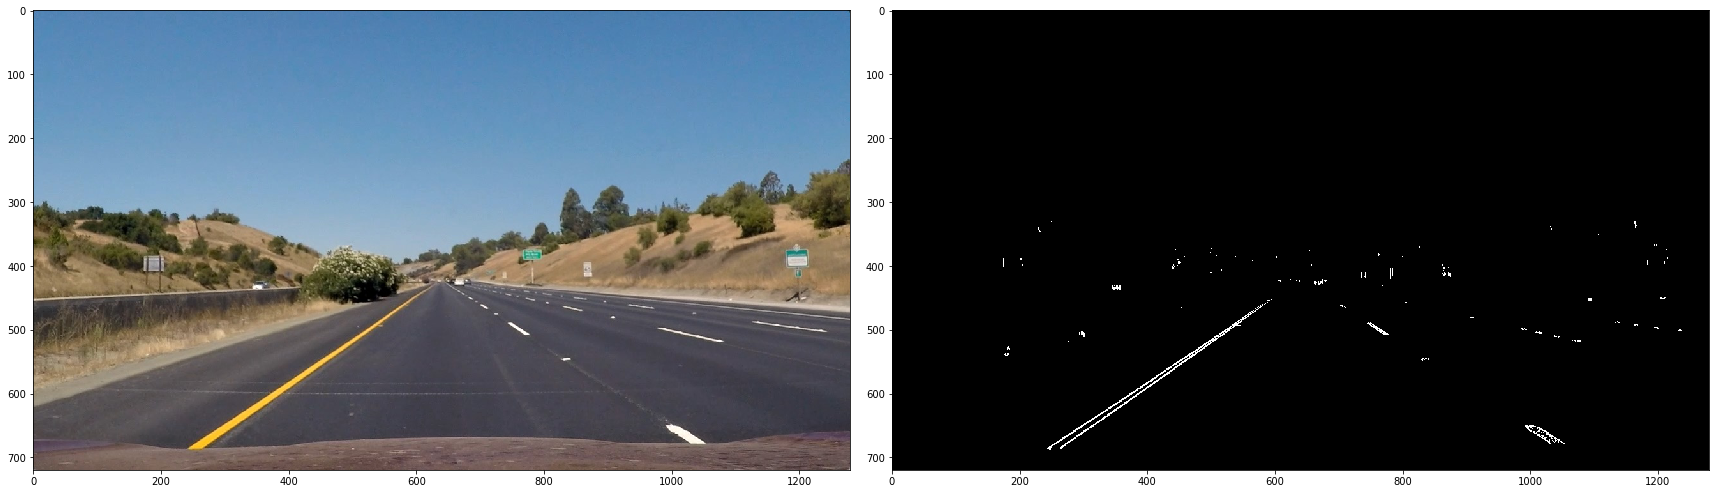

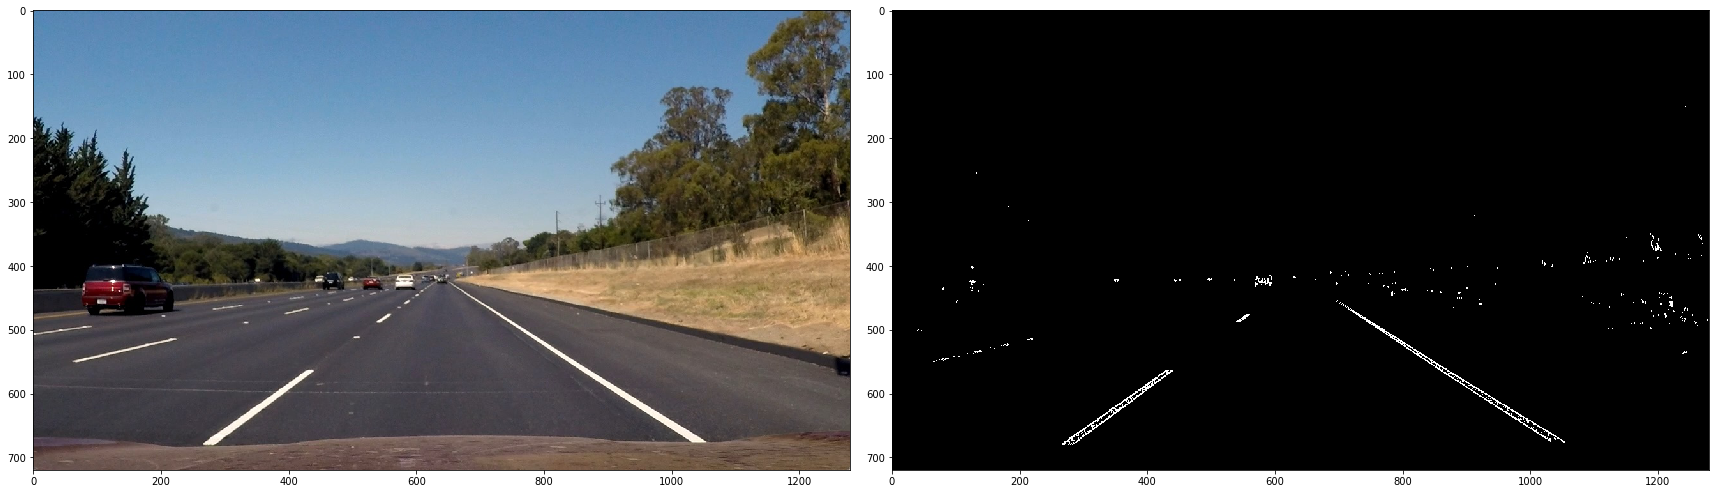

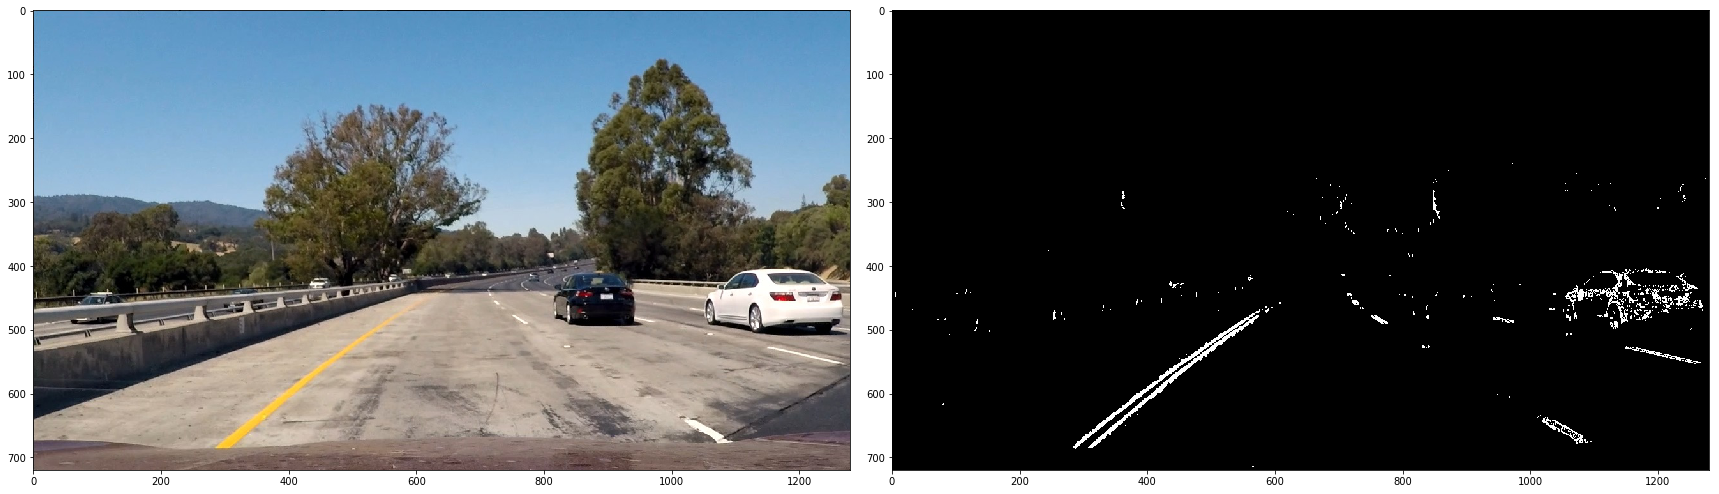

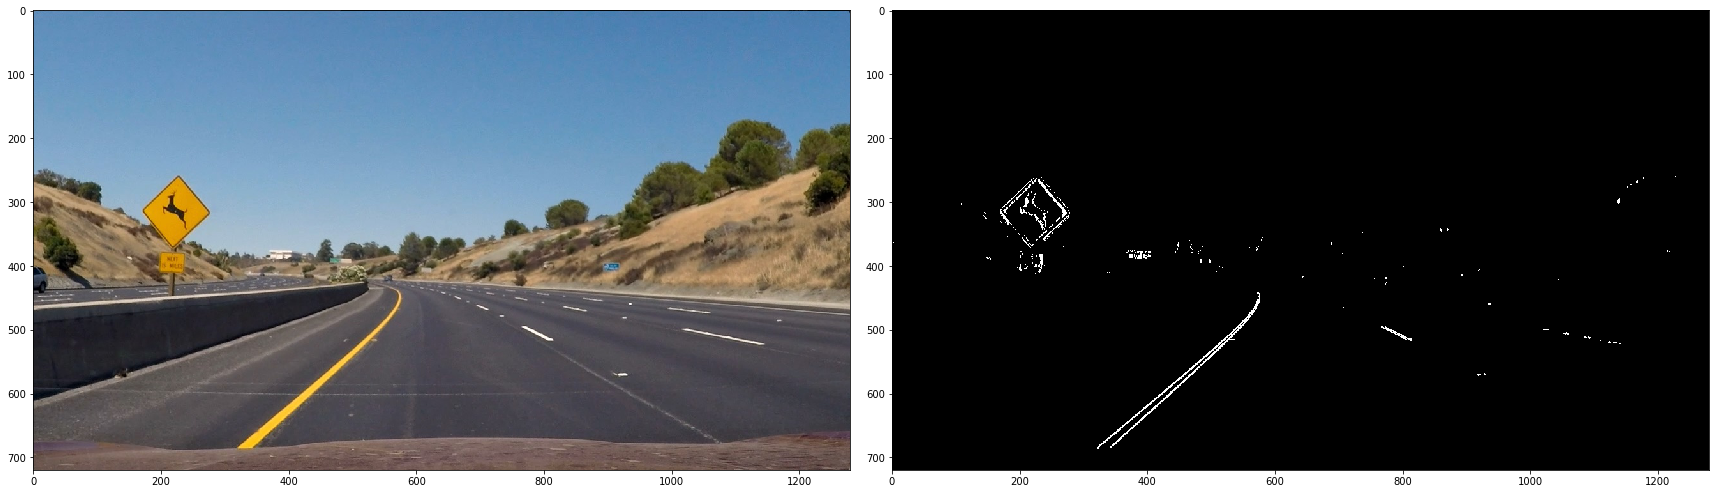

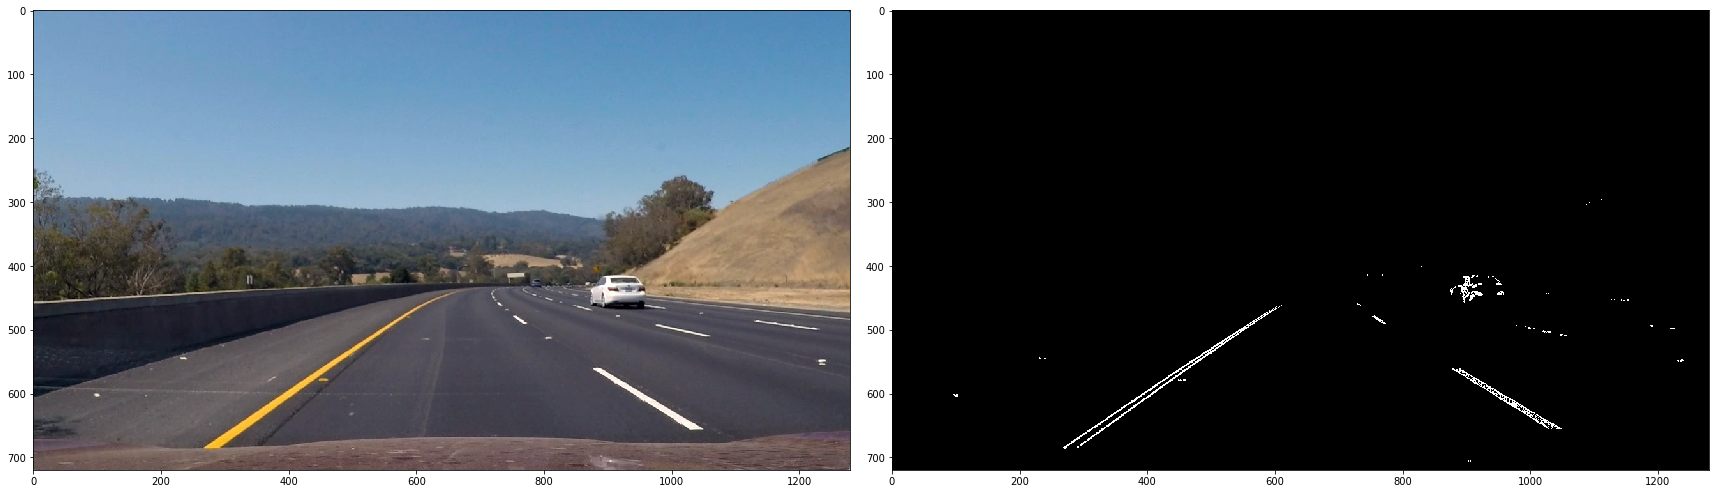

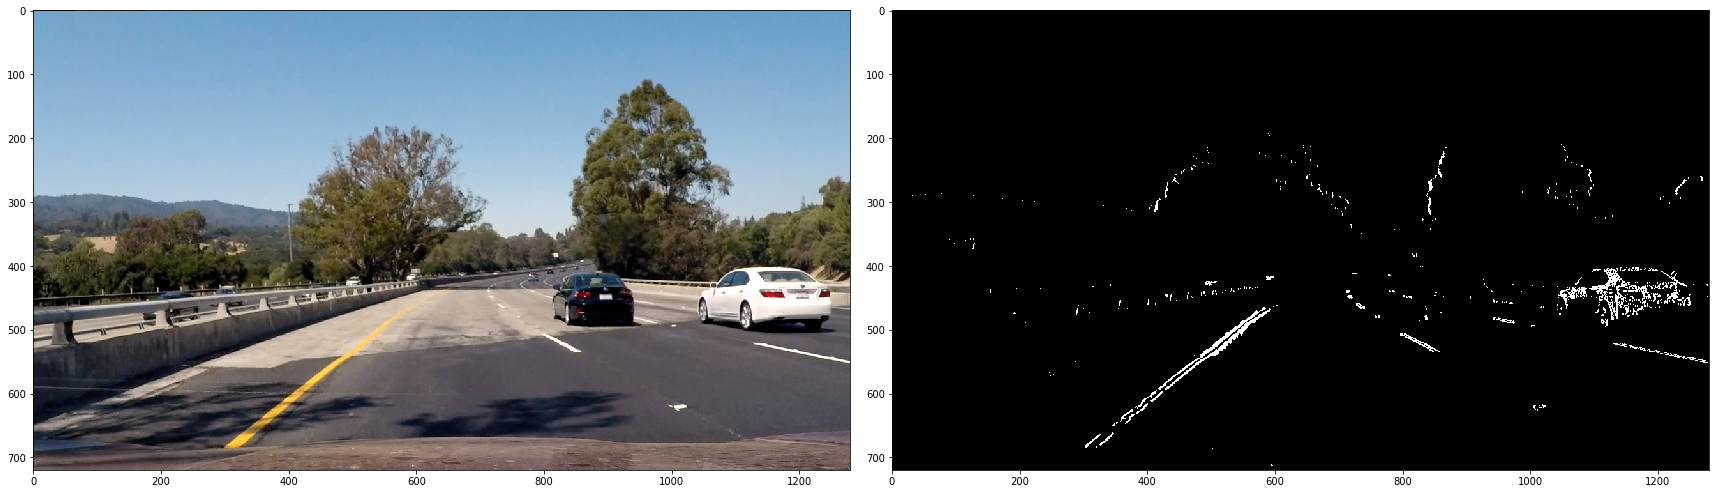

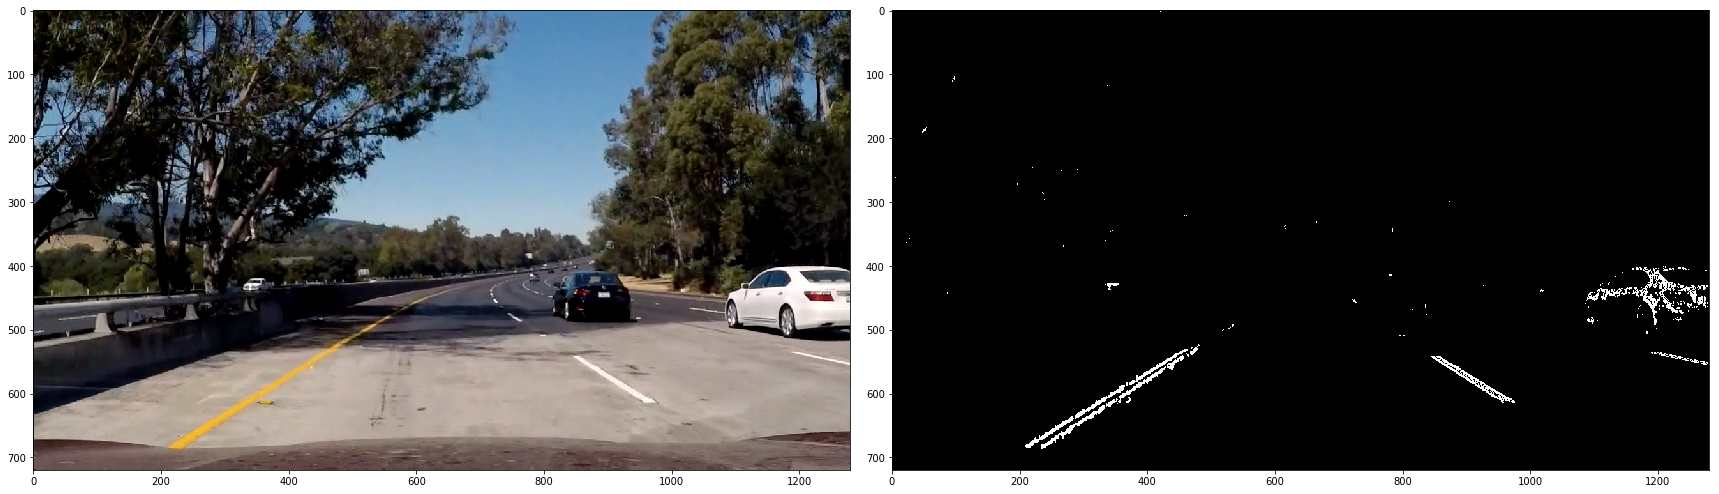

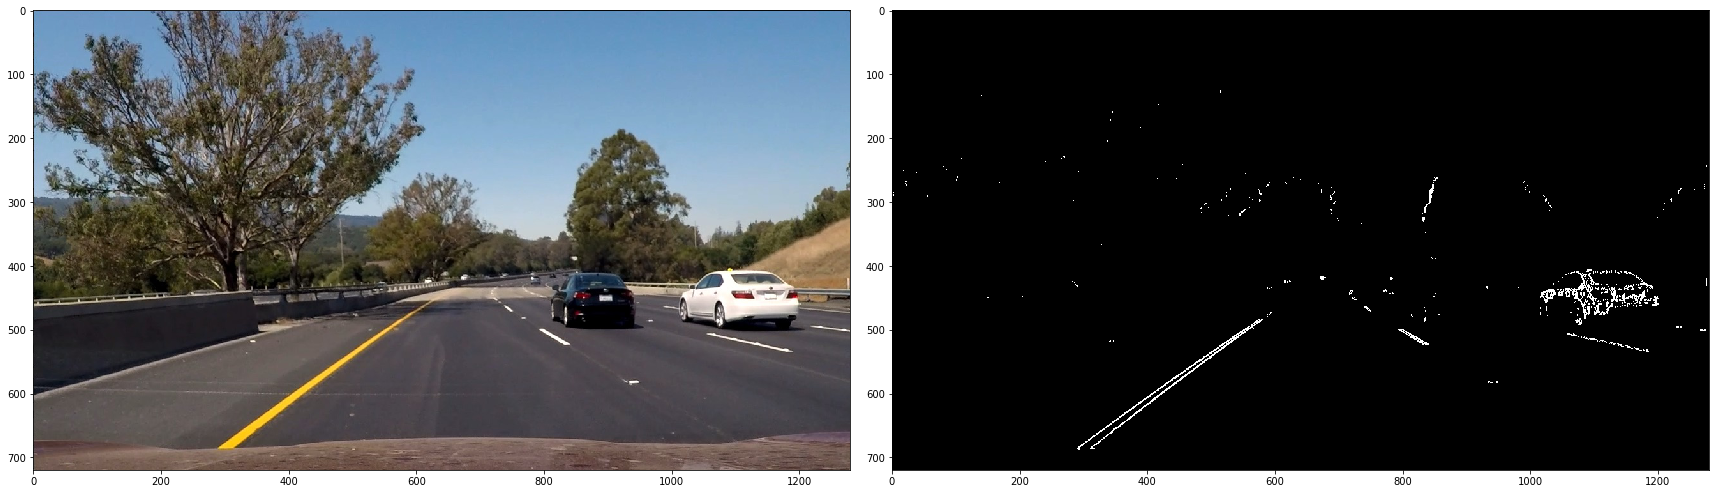

In [76]:
%matplotlib inline

images = glob.glob('./test_images/*.jpg')

for fname in images:
    img = cv2.imread(fname)
    processed = process_image(np.copy(img))
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 9))
    f.tight_layout()
    
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax2 = plt.imshow(processed, cmap='gray')
    plt.show()
